# VideoMAE 2D Training Notebook

This notebook trains a 2D MAE model using the latest dataset strucure:
- Build a 2D MAE (ResNet18 backbone + lightweight decoder)
- Train and log metrics to TensorBoard



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -rf VSD_foundation_model
!git clone --branch sharpen_dataset_and_dataloader https://github.com/ossnat/VSD_foundation_model.git
!ln -s '/content/drive/My Drive/VSD_FM/Data' '/content'

Cloning into 'VSD_foundation_model'...
remote: Enumerating objects: 629, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 629 (delta 26), reused 12 (delta 5), pack-reused 542 (from 1)
Receiving objects: 100% (629/629), 7.45 MiB | 17.94 MiB/s, done.
Resolving deltas: 100% (365/365), done.


In [3]:
# Imports and configuration
import os
import sys
import yaml
import torch
from torch.utils.data import DataLoader, Subset
from pathlib import Path

project_root = Path('VSD_foundation_model')
sys.path.insert(0, str(project_root))

from src.data import load_dataset, create_dataset, VsdVideoDataset
from src.models.backbone.mae_backbone_2d import MAEResNet18Backbone
from src.models.heads.mae_decoder_2d import MAEDecoder2D
from src.models.systems.mae_system import MAESystem
from src.utils.logger import TBLogger, set_seed
from src.training.trainer import Trainer

# Load config
config_path = "VSD_foundation_model/configs/VideoMAE_2D.yaml"
with open(config_path, 'r') as f:
  cfg = yaml.safe_load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using device: cpu


In [4]:
batch_size=32
train_loader = load_dataset(cfg, split="train", batch_size=batch_size, num_workers=0, shuffle=False)

Loading split CSV from Data/FoundationData/ProcessedData/splits/split_v1_seed17_strat_monkey.csv...
Successfully read CSV with standard settings
Found CSV columns (10 total): ['trial_global_id', 'monkey', 'date', 'condition', 'source_file', 'target_file', 'trial_index_in_condition', 'shape', 'trial_dataset', 'split']
CSV shape: (5706, 10) (rows x columns)
Required columns found: ['target_file', 'trial_dataset', 'shape', 'split'] out of ['target_file', 'trial_dataset', 'shape', 'split']
Sample first row (showing required columns):
  target_file: Data/FoundationData/ProcessedData/boromir/session_220622d_condsAN.h5
  trial_dataset: trial_000008
  shape: (10000, 256)
  split: train
Found 3994 trials for split 'train'
Loading stats from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.json...
Loading mean and std from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.h5...
Loaded normalization stats from H5 file:
  Mean range: [0.99

In [5]:
val_loader = load_dataset(cfg, split="val", batch_size=batch_size, num_workers=0, shuffle=False)

Loading split CSV from Data/FoundationData/ProcessedData/splits/split_v1_seed17_strat_monkey.csv...
Successfully read CSV with standard settings
Found CSV columns (10 total): ['trial_global_id', 'monkey', 'date', 'condition', 'source_file', 'target_file', 'trial_index_in_condition', 'shape', 'trial_dataset', 'split']
CSV shape: (5706, 10) (rows x columns)
Required columns found: ['target_file', 'trial_dataset', 'shape', 'split'] out of ['target_file', 'trial_dataset', 'shape', 'split']
Sample first row (showing required columns):
  target_file: Data/FoundationData/ProcessedData/boromir/session_220622d_condsAN.h5
  trial_dataset: trial_000008
  shape: (10000, 256)
  split: train
Found 856 trials for split 'val'
Loading stats from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.json...
Loading mean and std from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.h5...
Loaded normalization stats from H5 file:
  Mean range: [0.9996,

In [6]:
test_loader = load_dataset(cfg, split="test", batch_size=batch_size, num_workers=0, shuffle=False)

Loading split CSV from Data/FoundationData/ProcessedData/splits/split_v1_seed17_strat_monkey.csv...
Successfully read CSV with standard settings
Found CSV columns (10 total): ['trial_global_id', 'monkey', 'date', 'condition', 'source_file', 'target_file', 'trial_index_in_condition', 'shape', 'trial_dataset', 'split']
CSV shape: (5706, 10) (rows x columns)
Required columns found: ['target_file', 'trial_dataset', 'shape', 'split'] out of ['target_file', 'trial_dataset', 'shape', 'split']
Sample first row (showing required columns):
  target_file: Data/FoundationData/ProcessedData/boromir/session_220622d_condsAN.h5
  trial_dataset: trial_000008
  shape: (10000, 256)
  split: train
Found 856 trials for split 'test'
Loading stats from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.json...
Loading mean and std from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.h5...
Loaded normalization stats from H5 file:
  Mean range: [0.9996

In [7]:
# from src.models.backbone.mae_backbone_3d import MAER3D18Backbone
# from src.models.heads.mae_decoder_3d import MAEDecoder3D

# Build MAE 2D model and optimizer
encoder = MAEResNet18Backbone(pretrained=True, in_channels=1)
decoder = MAEDecoder2D(in_channels=encoder.feature_dim, out_channels=1, hidden_dim=256)

# Load config
model_config_path = "VSD_foundation_model/configs/model_configs/mae_2d_config.yaml"
with open(config_path, 'r') as f:
  model_cfg = yaml.safe_load(f)


model = MAESystem(encoder=encoder, decoder=decoder, config=model_cfg).to(device)
# Freeze encoder
for p in model.encoder.parameters():
    p.requires_grad = False

# (Optional) keep decoder trainable
for p in model.decoder.parameters():
    p.requires_grad = True

# Build optimizer on decoder params only
optimizer = torch.optim.AdamW(model.decoder.parameters(), lr=1e-4, weight_decay=0.05)
# optimizer = model.get_optimizer() # If you wish to train also encoder

print(model.__class__.__name__, "built.")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


MAESystem built.


In [8]:
# Train using generic Trainer (supports MAE 2D/3D and DINO)
logger = TBLogger(log_dir="logs")
trainer = Trainer(model=model, logger=logger, cfg=model_cfg, device=device)
trainer.fit(train_loader, val_loader)


/content/VSD_foundation_model/src/training/trainer.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/cuda/amp/grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(
Epoch 1/3:   0%|          | 0/15103 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/content/VSD_foundation_model/src/training/trainer.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CU

KeyboardInterrupt: 

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Define the log directory (matching the one used by TBLogger)
log_dir = "logs"

# Find the latest event file in the log directory
event_file = None
for root, dirs, files in os.walk(log_dir):
    for f in files:
        if "events.out.tfevents" in f:
            event_file = os.path.join(root, f)
            break
    if event_file:
        break

if event_file:
    print(f"Found TensorBoard event file: {event_file}")
    # Initialize EventAccumulator to read logs
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()

    # Get scalar data for 'train/loss'
    if 'train/loss' in event_acc.Tags()['scalars']:
        loss_events = event_acc.Scalars('train/loss')
        losses = [event.value for event in loss_events]
        steps = [event.step for event in loss_events]

        if len(losses) > 0:
            print(f"Found {len(losses)} loss values.")

            # Calculate rolling mean for every 10 iterations
            window_size = 10
            if len(losses) >= window_size:
                rolling_means = []
                rolling_steps = []
                for i in range(len(losses) - window_size + 1):
                    rolling_means.append(np.mean(losses[i : i + window_size]))
                    # Use the last step of the window for plotting
                    rolling_steps.append(steps[i + window_size - 1])

                # Plotting the rolling mean
                plt.figure(figsize=(10, 6))
                plt.plot(rolling_steps, rolling_means, label=f'Train Loss (Rolling Mean over {window_size} iterations)')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.title(f'Train Loss Rolling Mean (Every {window_size} Iterations)')
                plt.legend()
                plt.grid(True)
                plt.show()
                print(f"✅ Plotted rolling mean of loss over {window_size} iterations.")
            else:
                print(f"Not enough loss data ({len(losses)} points) to calculate rolling mean over {window_size} iterations. Plotting raw loss instead.")
                # Plot raw loss if not enough for rolling mean
                plt.figure(figsize=(10, 6))
                plt.plot(steps, losses, label='Train Loss (Raw)')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.title('Train Loss (Raw values)')
                plt.legend()
                plt.grid(True)
                plt.show()
                print("✅ Plotted raw loss values.")
        else:
            print("No 'train/loss' scalar data found in event file.")
    else:
        print("No 'train/loss' scalar tag found in event file.")
        print(f"Available scalar tags: {event_acc.Tags()['scalars']}")
else:
    print(f"No TensorBoard event files found in '{log_dir}'. Training might not have generated logs yet or was interrupted too early.")


In [ ]:
import torch
import numpy as np

def check_nan_in_weights(model):
    print("Checking for NaN values in model weights...")
    nan_found = False
    for name, param in model.named_parameters():
        if param.requires_grad and param.data is not None:
            # Move to CPU and convert to numpy for NaN check
            data = param.data.detach().cpu().numpy()
            if np.isnan(data).any():
                print(f"⚠️ NaN values found in weights of: {name}")
                nan_found = True
            else:
                print(f"No NaN values in weights of: {name}")
        else:
            print(f"Skipping {name}: Not a trainable parameter or no data.")

    if not nan_found:
        print("✅ No NaN values found in any trainable model weights.")
    else:
        print("❌ NaN values detected in some model weights.")

check_nan_in_weights(model)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_weights_histogram(model):
    print("Plotting histograms for model weights...")
    for name, param in model.named_parameters():
        if param.requires_grad and param.data is not None:
            data = param.data.detach().cpu().numpy()
            # Flatten the data to plot a single histogram
            data = data.reshape(-1)

            # Filter out NaN values if any (though unlikely for weights)
            data = data[~np.isnan(data)]

            if data.size > 0:
                plt.figure(figsize=(8, 5))
                plt.hist(data, bins=100, color='skyblue', edgecolor='black')
                plt.title(f'Histogram of Weights for: {name}')
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Skipping {name}: No valid weight data to plot.")
        else:
            print(f"Skipping {name}: Not a trainable parameter or no data.")
    print("✅ All weight histograms plotted.")

plot_weights_histogram(model)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Dimensionality is 2D (single frame). Plotting multiple batch items.


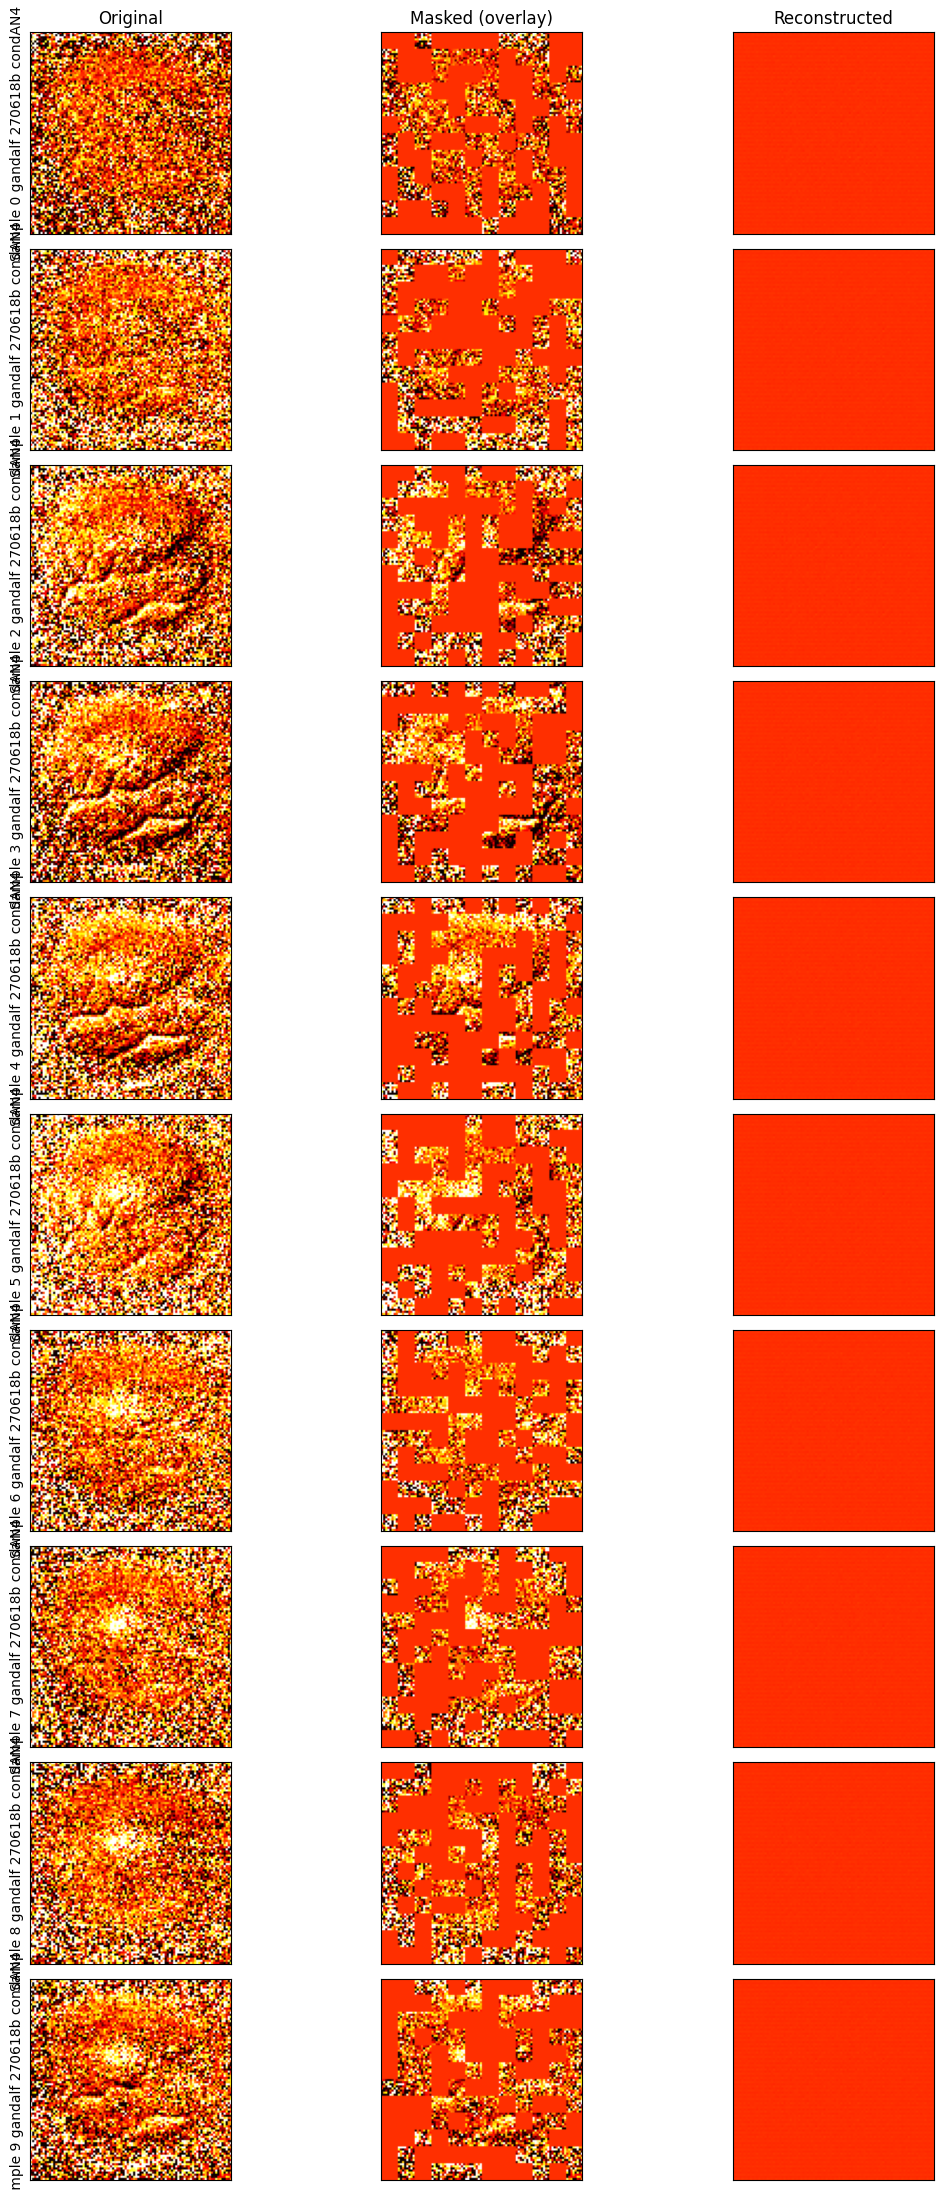

✅ Sequence visualization complete (rows=batch_items, cols=[orig, masked+overlay, recon]).


In [20]:
from datetime import date
# Sequence visualization: plot Original, Masked(+overlay), Reconstructed vertically over time
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define a minimal version
def get_reconstruction(model, batch):
    model.eval()
    with torch.no_grad():
        video_masked = batch["video_masked"]
        video_target = batch["video_target"]
        mask = batch["mask"]
        is_2d = False
        if len(video_target.shape) == 5 and video_target.shape[2] == 1:
            is_2d = True
            video_masked = video_masked.squeeze(2)
            video_target = video_target.squeeze(2)
            if len(mask.shape) == 5:
                mask = mask.squeeze(2)
            if len(mask.shape) == 4 and mask.shape[1] == 1:
                H, W = video_target.shape[2], video_target.shape[3]
                mask = F.interpolate(mask, size=(H, W), mode='nearest')
        features = model.encoder(video_masked)
        if is_2d or len(video_target.shape) == 4:
            target_size = (video_target.shape[2], video_target.shape[3])
            reconstruction = model.decoder(features, target_size=target_size)
        else:
            target_size = (video_target.shape[2], video_target.shape[3], video_target.shape[4])
            reconstruction = model.decoder(features, target_size=target_size)
            if len(mask.shape) == 5 and mask.shape[1] == 1:
                T, H, W = video_target.shape[2], video_target.shape[3], video_target.shape[4]
                mask = F.interpolate(mask, size=(T, H, W), mode='nearest')
        return reconstruction, mask, video_target, video_masked

# Fetch a validation batch and reconstruct
model.eval()
val_sample = next(iter(val_loader))
val_sample = {k: v.to(device) if torch.is_tensor(v) else v
                             for k, v in val_sample.items()}
reconstruction, mask, original, masked = get_reconstruction(model, val_sample)

# Determine dimensionality
# 2D: (B,C,H,W); 3D: (B,C,T,H,W)

if original.ndim == 4:  # 2D case: (B,C,H,W) - plot multiple batch items
    print("Dimensionality is 2D (single frame). Plotting multiple batch items.")
    max_batch_items_to_plot = 10
    num_items = min(original.shape[0], max_batch_items_to_plot)

    # Calculate vmin and vmax using percentiles across all selected batch items for better visualization
    selected_originals_flat = original[:num_items, 0, :, :].cpu().numpy().flatten()
    vmin, vmax = np.percentile(selected_originals_flat, 10), np.percentile(selected_originals_flat, 90)

    fig, axes = plt.subplots(num_items, 3, figsize=(12, 2.2 * num_items))
    if num_items == 1:
        axes = np.array([axes]) # Ensure axes is 2D even for single row

    for b_idx in range(num_items):
        monkey = val_sample['monkey'][b_idx]
        date = val_sample['date'][b_idx]
        condition = val_sample['condition'][b_idx]

        # Original
        axes[b_idx, 0].imshow(original[b_idx, 0].cpu().numpy(), cmap='hot', vmin=vmin, vmax=vmax)
        axes[b_idx, 0].set_ylabel(f"Sample {b_idx} {monkey} {date} {condition}")
        axes[b_idx, 0].set_xticks([]); axes[b_idx, 0].set_yticks([])
        if b_idx == 0:
            axes[b_idx, 0].set_title('Original')

        # Masked + overlay
        masked_frame = masked[b_idx, 0].cpu().numpy()
        mask_frame = mask[b_idx, 0].cpu().numpy()
        # Resize mask if it's smaller than the video frame (happens with pooling)
        if mask_frame.shape != masked_frame.shape:
             mask_frame_tensor = torch.from_numpy(mask_frame).unsqueeze(0).unsqueeze(0) # (1,1,H_mask,W_mask)
             mask_frame = F.interpolate(mask_frame_tensor, size=masked_frame.shape, mode='nearest').squeeze().numpy()
        overlay = np.zeros((*mask_frame.shape, 4), dtype=np.float32) # Use new mask_frame shape
        overlay[..., 0] = 1.0
        overlay[..., 3] = 0.3 * (1.0 - mask_frame)  # red where masked
        axes[b_idx, 1].imshow(masked_frame, cmap='hot', vmin=vmin, vmax=vmax)
        axes[b_idx, 1].imshow(overlay)
        axes[b_idx, 1].set_xticks([]); axes[b_idx, 1].set_yticks([])
        if b_idx == 0:
            axes[b_idx, 1].set_title('Masked (overlay)')

        # Reconstructed
        recon_frame = reconstruction[b_idx, 0].cpu().numpy()
        axes[b_idx, 2].imshow(recon_frame, cmap='hot', vmin=vmin, vmax=vmax)
        axes[b_idx, 2].set_xticks([]); axes[b_idx, 2].set_yticks([])
        if b_idx == 0:
            axes[b_idx, 2].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()
    print("✅ Sequence visualization complete (rows=batch_items, cols=[orig, masked+overlay, recon]).")

else:  # 3D case: (B,C,T,H,W) - plot first batch item over time
    print("Dimensionality is 3D (video). Plotting first batch item over time.")
    b = 0 # Select first item in batch

    # Calculate vmin and vmax using percentiles for better visualization
    original_flat = original[b, 0, :, :, :].cpu().numpy().flatten() # For 3D, original has B,C,T,H,W
    vmin, vmax = np.percentile(original_flat, 10), np.percentile(original_flat, 90)

    T = original.shape[2]
    orig_frames = original[b, 0].cpu()          # (T,H,W)
    masked_frames = masked[b, 0].cpu()          # (T,H,W)
    recon_frames = reconstruction[b, 0].cpu()   # (T,H,W)
    mask_frames = mask[b, 0].cpu()              # (T,H,W) after model fix (assuming get_reconstruction handles resize)

    # Limit number of frames for display
    max_rows = 12
    rows = min(T, max_rows)
    fig, axes = plt.subplots(rows, 3, figsize=(12, 2.2*rows))
    if rows == 1:
        axes = np.array([axes]) # Ensure axes is 2D even for single row

    for t in range(rows):
        # Original
        axes[t, 0].imshow(orig_frames[t].cpu().numpy() if torch.is_tensor(orig_frames[t]) else orig_frames[t], cmap='hot', vmin=vmin, vmax=vmax)
        axes[t, 0].set_ylabel(f"t={t}")
        axes[t, 0].set_xticks([]); axes[t, 0].set_yticks([])
        if t == 0:
            axes[t, 0].set_title('Original')

        # Masked + overlay
        im = axes[t, 1].imshow(masked_frames[t].cpu().numpy() if torch.is_tensor(masked_frames[t]) else masked_frames[t], cmap='hot', vmin=vmin, vmax=vmax)
        m = mask_frames[t].cpu().numpy() if torch.is_tensor(mask_frames[t]) else mask_frames[t]
        # Check if mask_frame needs interpolation (e.g., if mask is patch-based and smaller than image)
        if m.shape != masked_frames[t].shape:
            m_tensor = torch.from_numpy(m).unsqueeze(0).unsqueeze(0) # (1,1,H_mask,W_mask)
            m = F.interpolate(m_tensor, size=masked_frames[t].shape, mode='nearest').squeeze().numpy()
        overlay = np.zeros((m.shape[0], m.shape[1], 4), dtype=np.float32) # Use new m shape
        overlay[..., 0] = 1.0
        overlay[..., 3] = 0.3 * (1.0 - m)  # red where masked
        axes[t, 1].imshow(overlay)
        axes[t, 1].set_xticks([]); axes[t, 1].set_yticks([])
        if t == 0:
            axes[t, 1].set_title('Masked (overlay)')

        # Reconstructed
        axes[t, 2].imshow(recon_frames[t].cpu().numpy() if torch.is_tensor(recon_frames[t]) else recon_frames[t], cmap='hot', vmin=vmin, vmax=vmax)
        axes[t, 2].set_xticks([]); axes[t, 2].set_yticks([])
        if t == 0:
            axes[t, 2].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()
    print("✅ Sequence visualization complete (rows=time, cols=[orig, masked+overlay, recon]).")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_recon_hist(recon_frames, bins=100, title="Reconstruction pixel histogram"):
    # Move tensor to CPU and flatten
    if torch.is_tensor(recon_frames):
        data = recon_frames.detach().cpu().numpy()
    else:
        data = np.asarray(recon_frames)

    data = data.reshape(-1)

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=bins, color="steelblue", alpha=0.8)
    plt.title(title)
    plt.xlabel("Pixel value")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_recon_hist(recon_frames)